<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Data Cleaning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date
from sklearn.cluster import KMeans

## Order Dataset

In [3]:
order_df = pd.read_csv('olist_orders_dataset.csv')
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
order_df[order_df.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [5]:
order_df.drop(['order_status', 'order_delivered_carrier_date', 'order_approved_at'], axis='columns', inplace=True)
for column in ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    order_df[column] = pd.to_datetime(order_df[column])
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_purchase_timestamp         99441 non-null datetime64[ns]
order_delivered_customer_date    96476 non-null datetime64[ns]
order_estimated_delivery_date    99441 non-null datetime64[ns]
dtypes: datetime64[ns](3), object(2)
memory usage: 3.8+ MB


In [6]:
order_df.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26


## Payment Dataset

In [7]:
payment_df = pd.read_csv('olist_order_payments_dataset.csv')
payment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
order_id                103886 non-null object
payment_sequential      103886 non-null int64
payment_type            103886 non-null object
payment_installments    103886 non-null int64
payment_value           103886 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [8]:
payment_df[payment_df.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [9]:
payment_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [10]:
payment_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [11]:
payment_df.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

## Customer Dataset

In [12]:
customer_df = pd.read_csv('olist_customers_dataset.csv')
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [13]:
customer_df[customer_df.duplicated()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [14]:
customer_df.drop(['customer_zip_code_prefix', 'customer_city'], axis='columns', inplace=True)

In [15]:
customer_df.nunique()

customer_id           99441
customer_unique_id    96096
customer_state           27
dtype: int64

In [16]:
customer_df.head()

,customer_id,customer_unique_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP


## Item Dataset

In [17]:
item_df = pd.read_csv('olist_order_items_dataset.csv')

In [18]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null object
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
item_df[item_df.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [20]:
item_df.drop(['seller_id',
              'shipping_limit_date',
              'price',
              'freight_value',
              'order_item_id'], axis='columns', inplace=True)
item_df.columns

Index(['order_id', 'product_id'], dtype='object')

In [21]:
item_df.head()

,order_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089


## Product Dataset

In [22]:
product_df = pd.read_csv('olist_products_dataset.csv')

In [23]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [24]:
product_df[product_df.duplicated()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [25]:
product_df.drop(['product_name_lenght',
                 'product_description_lenght', 
                 'product_photos_qty', 
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'product_width_cm'], axis='columns', inplace=True)

In [26]:
product_df.fillna('other', inplace=True)
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 2 columns):
product_id               32951 non-null object
product_category_name    32951 non-null object
dtypes: object(2)
memory usage: 515.0+ KB


In [27]:
product_df.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [28]:
product_df.product_category_name.nunique()

74

## Translation Dataset

In [29]:
translation_df = pd.read_csv('product_category_name_translation.csv')
translation_df.info()
translation_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
product_category_name            71 non-null object
product_category_name_english    71 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


## Review Dataset

In [30]:
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null object
review_answer_timestamp    100000 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [31]:
review_df[review_df.duplicated()]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [32]:
review_df.drop(['review_id', 'review_creation_date', 'review_answer_timestamp'], axis='columns', inplace=True)
review_df.columns

Index(['order_id', 'review_score', 'review_comment_title',
       'review_comment_message'],
      dtype='object')

In [33]:
for columns in ['review_comment_title', 'review_comment_message']:
    # replace present values with 1
    review_df.loc[review_df[columns].notnull(), columns] = 1
    # replace null values with 0
    review_df.loc[review_df[columns].isna(), columns] = 0
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
order_id                  100000 non-null object
review_score              100000 non-null int64
review_comment_title      100000 non-null int64
review_comment_message    100000 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [34]:
review_df.head()

,order_id,review_score,review_comment_title,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,0,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0
3,658677c97b385a9be170737859d3511b,5,0,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1


In [35]:
review_df.nunique()

order_id                  99441
review_score                  5
review_comment_title          2
review_comment_message        2
dtype: int64

# Exploratory Data Analytics with Raw Data

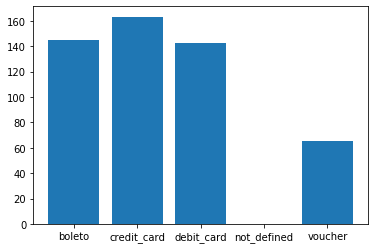

In [36]:
plt.bar(payment_df.groupby('payment_type').sum().index, 
        payment_df.groupby('payment_type').sum()['payment_value']/payment_df.groupby('payment_type').count()['payment_value']);

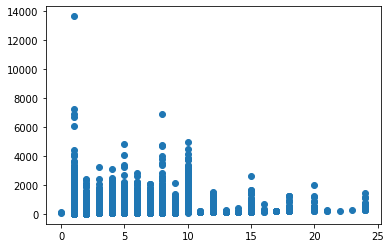

In [37]:
plt.scatter(payment_df.payment_installments, payment_df.payment_value);

<BarContainer object of 5 artists>

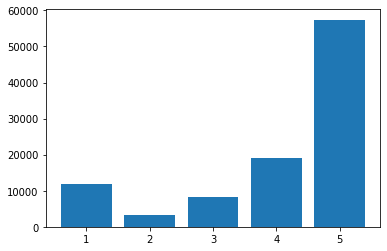

In [155]:
plt.bar(review_df.review_score.value_counts().index, review_df.review_score.value_counts().values)

In [39]:
po_df = pd.merge(payment_df, order_df, how='left', on='order_id')
po_df.info()
po_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 9 columns):
order_id                         103886 non-null object
payment_sequential               103886 non-null int64
payment_type                     103886 non-null object
payment_installments             103886 non-null int64
payment_value                    103886 non-null float64
customer_id                      103886 non-null object
order_purchase_timestamp         103886 non-null datetime64[ns]
order_delivered_customer_date    100754 non-null datetime64[ns]
order_estimated_delivery_date    103886 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2), object(3)
memory usage: 7.9+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-07-16
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,2017-12-18 17:24:41,2018-01-04
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,2018-06-01 21:44:53,2018-06-13


In [40]:
poc_df = pd.merge(po_df, customer_df, how='left', on='customer_id')
poc_df.drop('customer_id', axis='columns', inplace=True)
poc_df.info()
poc_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 10 columns):
order_id                         103886 non-null object
payment_sequential               103886 non-null int64
payment_type                     103886 non-null object
payment_installments             103886 non-null int64
payment_value                    103886 non-null float64
order_purchase_timestamp         103886 non-null datetime64[ns]
order_delivered_customer_date    100754 non-null datetime64[ns]
order_estimated_delivery_date    103886 non-null datetime64[ns]
customer_unique_id               103886 non-null object
customer_state                   103886 non-null object
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 8.7+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,2017-12-12 11:19:55,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,2018-05-21 13:59:17,2018-06-01 21:44:53,2018-06-13,4291db0da71914754618cd789aebcd56,SP


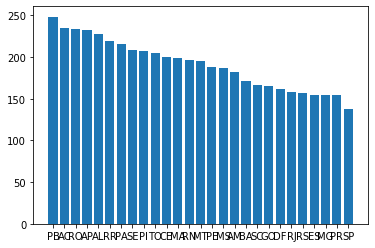

In [41]:
state_pay_series = poc_df.groupby('customer_state').sum()['payment_value']/poc_df.groupby('customer_state').count()['payment_value']
state_pay_series.sort_values(inplace=True, ascending=False)
plt.bar(state_pay_series.index, state_pay_series);

In [42]:
poci_df = pd.merge(poc_df, item_df, how='right', on='order_id')
poci_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 11 columns):
order_id                         117604 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_id                       117604 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


In [43]:
poci_df.drop(poci_df[poci_df.payment_value.isnull()].index, axis='index', inplace=True)
poci_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 11 columns):
order_id                         117601 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_id                       117601 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


In [44]:
pocip_df = pd.merge(poci_df, product_df, how='left', on='product_id')
pocip_df.drop('product_id', axis='columns', inplace=True)
pocip_df.info()
pocip_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 11 columns):
order_id                         117601 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_category_name            117601 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,product_category_name
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,MG,casa_construcao
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,SP,automotivo
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,2017-12-12 11:19:55,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho
4,42fdf880ba16b47b59251dd489d4441a,1.0,credit_card,2.0,128.45,2018-05-21 13:59:17,2018-06-01 21:44:53,2018-06-13,4291db0da71914754618cd789aebcd56,SP,cama_mesa_banho


In [45]:
#df = pd.merge(df, translation_df, how='left', on='product_category_name')
#df.drop('product_category_name', axis='columns', inplace=True)
#df.head()

<BarContainer object of 74 artists>

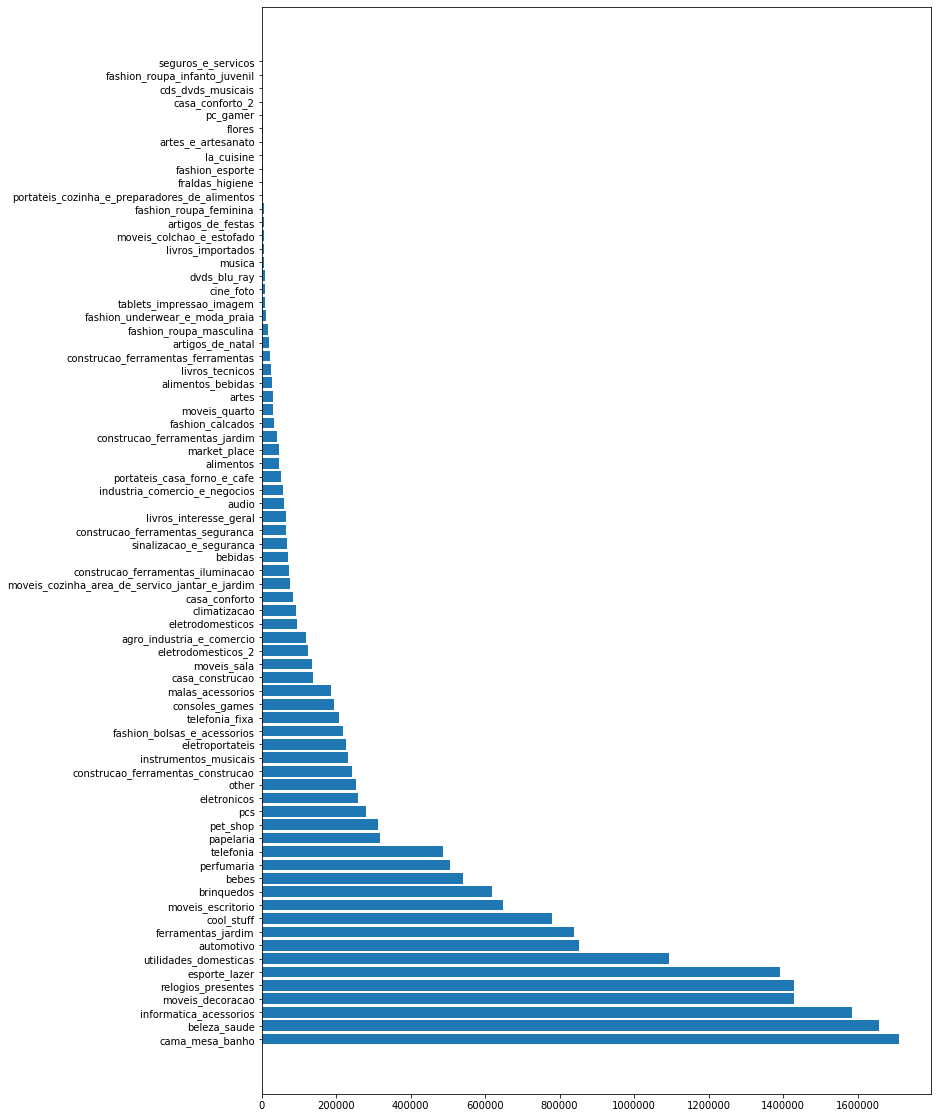

In [46]:
payment_by_category = pocip_df.groupby('product_category_name')['payment_value'].sum()
payment_by_category.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12,20))
plt.barh(payment_by_category.index, payment_by_category)

In [47]:
pocipr_df = pd.merge(pocip_df, review_df, how='right', on='order_id')
pocipr_df.info()
pocipr_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119094 entries, 0 to 119093
Data columns (total 14 columns):
order_id                         119094 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     119094 non-null int64
review_comment_title             119094 non-null int64
review_comment_message           119094 non-null int64
dtypes: datetime64[ns](3), float64(3), int64(3), object(5)
memory usage: 13.6+ MB

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,product_category_name,review_score,review_comment_title,review_comment_message
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,MG,casa_construcao,1,1,1
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,SP,automotivo,5,0,0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,2017-12-12 11:19:55,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria,5,0,1
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0
4,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0


In [48]:
pocipr_df.drop(pocipr_df[pocipr_df.payment_value.isnull()].index, axis='index', inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
dtypes: datetime64[ns](3), float64(3), int64(3), object(5)
memory usage: 13.5+ MB

# Feature Engineering

In [49]:
pocipr_df['purchase_date'] = pocipr_df['order_purchase_timestamp'].dt.date
pocipr_df['delay'] = (pocipr_df.order_delivered_customer_date - pocipr_df.order_estimated_delivery_date).dt.days
pocipr_df.drop(['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis='columns', inplace=True)
pocipr_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_state,product_category_name,review_score,review_comment_title,review_comment_message,purchase_date,delay
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,708ab75d2a007f0564aedd11139c7708,MG,casa_construcao,1,1,1,2018-04-25,-13.0
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,a8b9d3a27068454b1c98cc67d4e31e6f,SP,automotivo,5,0,0,2018-06-26,-17.0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria,5,0,1,2017-12-12,-17.0
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0
4,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0


In [50]:
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
order_id                  118315 non-null object
payment_sequential        118315 non-null float64
payment_type              118315 non-null object
payment_installments      118315 non-null float64
payment_value             118315 non-null float64
customer_unique_id        118315 non-null object
customer_state            118315 non-null object
product_category_name     118315 non-null object
review_score              118315 non-null int64
review_comment_title      118315 non-null int64
review_comment_message    118315 non-null int64
purchase_date             118315 non-null object
delay                     115727 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 12.6+ MB


In [51]:
pocipr_df.fillna(pocipr_df.median(), inplace=True)

In [52]:
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
order_id                  118315 non-null object
payment_sequential        118315 non-null float64
payment_type              118315 non-null object
payment_installments      118315 non-null float64
payment_value             118315 non-null float64
customer_unique_id        118315 non-null object
customer_state            118315 non-null object
product_category_name     118315 non-null object
review_score              118315 non-null int64
review_comment_title      118315 non-null int64
review_comment_message    118315 non-null int64
purchase_date             118315 non-null object
delay                     118315 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 12.6+ MB


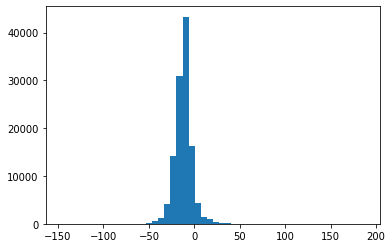

In [53]:
plt.hist(pocipr_df.delay, bins=50);

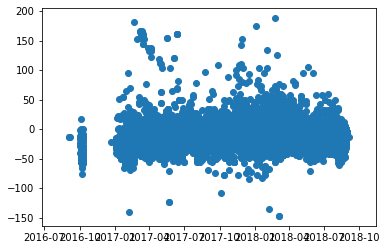

In [54]:
plt.scatter(pocipr_df.purchase_date, pocipr_df.delay);

In [55]:
pocipr_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_state,product_category_name,review_score,review_comment_title,review_comment_message,purchase_date,delay
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,708ab75d2a007f0564aedd11139c7708,MG,casa_construcao,1,1,1,2018-04-25,-13.0
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,a8b9d3a27068454b1c98cc67d4e31e6f,SP,automotivo,5,0,0,2018-06-26,-17.0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria,5,0,1,2017-12-12,-17.0
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0
4,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0


In [87]:
pocipr_df1 = pocipr_df[(date(2016,10,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,4,1))]
pocipr_df2 = pocipr_df[(date(2018,4,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,10,1))]
pocipr_df2 = pocipr_df2[['customer_unique_id', 'payment_value']]

In [88]:
pocipr_df1

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_state,product_category_name,review_score,review_comment_title,review_comment_message,purchase_date,delay
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria,5,0,1,2017-12-12,-17.0
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0
4,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho,5,0,0,2017-12-06,-14.0
8,771ee386b001f06208a7419e4fc1bbd7,1.0,credit_card,1.0,81.16,9a3526eee723accd014ec683afe5bf20,MG,utilidades_domesticas,5,0,1,2017-06-23,-14.0
9,3d7239c394a212faae122962df514ac7,1.0,credit_card,3.0,51.84,9db67268a3fee1d4b13faaeb90af07c0,SP,perfumaria,4,0,0,2017-06-05,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118308,2e3d96522c8c378d4135c12a65c977aa,1.0,credit_card,4.0,47.62,1c157ec47b1201b33c6ea9cc61c966fb,CE,telefonia,1,0,1,2017-11-23,-13.0
118310,0406037ad97740d563a178ecc7a2075c,1.0,boleto,1.0,363.31,b6027ac07fb76ebca8c97b1887865aee,SP,construcao_ferramentas_iluminacao,5,0,1,2018-03-08,-19.0
118311,7b905861d7c825891d6347454ea7863f,1.0,credit_card,2.0,96.80,53b30ca78efb2b7efcd3f9e461587eb2,MG,papelaria,5,0,0,2017-08-18,-20.0
118312,32609bbb3dd69b3c066a6860554a77bf,1.0,credit_card,1.0,47.77,d3c7da954a324253814096bcaf240e4e,SP,automotivo,1,0,0,2017-11-18,-13.0


In [89]:
pocipr_df2

,customer_unique_id,payment_value
0,708ab75d2a007f0564aedd11139c7708,99.33
1,a8b9d3a27068454b1c98cc67d4e31e6f,24.39
5,4291db0da71914754618cd789aebcd56,128.45
6,6e3c218d5f0434ddc4af3d6a60767bbf,96.12
7,6e3c218d5f0434ddc4af3d6a60767bbf,96.12
...,...,...
118292,6608c37202accfe3cda3fca4c8a16062,356.53
118303,7bce2e8bcb39be572c7ec072e5cc3130,91.03
118305,0b52c0db190fe9e3558ddcfa4407ea90,170.14
118309,13f283df2f4760f22b57830865761d07,198.94


# Exploratory Data Analytics

In [90]:
cust_pocipr_df1 = pocipr_df1.groupby('customer_unique_id').agg({'purchase_date': lambda x: min((max(pocipr_df1.purchase_date)-x).dt.days),  
                                                    'order_id': 'count',
                                                    'payment_value': 'sum',
                                                    'delay': 'mean',
                                                    'payment_installments': 'mean',
                                                    'review_score': 'mean',
                                                    'review_comment_title': 'mean',
                                                    'review_comment_message': 'mean',
                                           'payment_type': lambda x: x.value_counts().index[0],
                                           'product_category_name': lambda x: x.value_counts().index[0],
                                                'customer_state': lambda x: x.value_counts().index[0]})



ValueError: Length mismatch: Expected axis has 11 elements, new values have 10 elements

In [91]:
cust_pocipr_df1.columns = ['recency', 'frequency', 'monetary', 'delay', 'installments', 'review_score', 'comment_title', 'comment_message',
            'pop_payment_type', 'pop_category', 'customer_state']

cust_pocipr_df1

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,386,1,86.22,-2.0,8.0,3.0,0.0,0.0,credit_card,papelaria,SC
0000f6ccb0745a6a4b88665a16c9f078,170,1,43.62,-12.0,4.0,4.0,0.0,1.0,credit_card,telefonia,PA
0004aac84e0df4da2b147fca70cf8255,137,1,196.89,-8.0,6.0,5.0,0.0,0.0,credit_card,telefonia,SP
00053a61a98854899e70ed204dd4bafe,31,2,838.36,-10.0,3.0,1.0,0.0,1.0,credit_card,esporte_lazer,PR
0005e1862207bf6ccc02e4228effd9a0,392,1,150.12,-28.0,3.0,4.0,0.0,0.0,credit_card,fashion_bolsas_e_acessorios,RJ
...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,94,1,167.32,-14.0,2.0,5.0,0.0,0.0,credit_card,other,CE
fffcf5a5ff07b0908bd4e2dbc735a684,296,2,4134.84,-27.0,10.0,5.0,0.0,0.0,credit_card,beleza_saude,PE
fffea47cd6d3cc0a88bd621562a9d061,111,1,84.58,-3.0,1.0,4.0,0.0,0.0,credit_card,bebes,BA


In [92]:
cust_pocipr_df1.head()

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,386,1,86.22,-2.0,8.0,3.0,0.0,0.0,credit_card,papelaria,SC
0000f6ccb0745a6a4b88665a16c9f078,170,1,43.62,-12.0,4.0,4.0,0.0,1.0,credit_card,telefonia,PA
0004aac84e0df4da2b147fca70cf8255,137,1,196.89,-8.0,6.0,5.0,0.0,0.0,credit_card,telefonia,SP
00053a61a98854899e70ed204dd4bafe,31,2,838.36,-10.0,3.0,1.0,0.0,1.0,credit_card,esporte_lazer,PR
0005e1862207bf6ccc02e4228effd9a0,392,1,150.12,-28.0,3.0,4.0,0.0,0.0,credit_card,fashion_bolsas_e_acessorios,RJ


In [93]:
cust_pocipr_df1.to_csv('cust_pocipr_df1.csv', index=True);
#cust_pocipr_df1 = pd.read_csv('cust_pocipr_df1.csv', index_col=0)

In [74]:
cust_pocipr_df1

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category
customer_unique_id,,,,,,,,,,
0000f46a3911fa3c0805444483337064,204,1,86.22,-2.0,8.0,3.0,0,0.0,credit_card,papelaria
0005e1862207bf6ccc02e4228effd9a0,210,1,150.12,-28.0,3.0,4.0,0,0.0,credit_card,fashion_bolsas_e_acessorios
0006fdc98a402fceb4eb0ee528f6a8d4,74,1,29.00,-12.0,2.0,3.0,0,1.0,credit_card,cama_mesa_banho
000a5ad9c4601d2bbdd9ed765d5213b3,50,1,91.28,-15.0,3.0,4.0,0,0.0,credit_card,beleza_saude
000bfa1d2f1a41876493be685390d6d3,1,2,93.70,-13.0,4.0,4.5,0,0.5,credit_card,fashion_bolsas_e_acessorios
...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,50,1,102.74,-7.0,2.0,5.0,0,0.0,credit_card,malas_acessorios
fff699c184bcc967d62fa2c6171765f7,29,1,55.00,-7.0,1.0,4.0,0,1.0,boleto,consoles_games
fffcf5a5ff07b0908bd4e2dbc735a684,114,2,4134.84,-27.0,10.0,5.0,0,0.0,credit_card,beleza_saude


In [75]:
#cust_pocipr_df1['customer_state'] = pocipr_df1.groupby('customer_unique_id').agg({'customer_state': lambda x: x.value_counts().index[0]})
#cust_pocipr_df1

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,204,1,86.22,-2.0,8.0,3.0,0,0.0,credit_card,papelaria,SC
0005e1862207bf6ccc02e4228effd9a0,210,1,150.12,-28.0,3.0,4.0,0,0.0,credit_card,fashion_bolsas_e_acessorios,RJ
0006fdc98a402fceb4eb0ee528f6a8d4,74,1,29.00,-12.0,2.0,3.0,0,1.0,credit_card,cama_mesa_banho,ES
000a5ad9c4601d2bbdd9ed765d5213b3,50,1,91.28,-15.0,3.0,4.0,0,0.0,credit_card,beleza_saude,RS
000bfa1d2f1a41876493be685390d6d3,1,2,93.70,-13.0,4.0,4.5,0,0.5,credit_card,fashion_bolsas_e_acessorios,SP
...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,50,1,102.74,-7.0,2.0,5.0,0,0.0,credit_card,malas_acessorios,DF
fff699c184bcc967d62fa2c6171765f7,29,1,55.00,-7.0,1.0,4.0,0,1.0,boleto,consoles_games,SP
fffcf5a5ff07b0908bd4e2dbc735a684,114,2,4134.84,-27.0,10.0,5.0,0,0.0,credit_card,beleza_saude,PE


In [70]:
#cust_pocipr_df1 = pd.merge(cust_pocipr_df1, customer_df.set_index('customer_unique_id')['customer_state'], how='left', left_index=True, right_index=True)
#cust_pocipr_df1

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,204,1,86.22,-2.0,8.0,3.0,0,0.0,credit_card,papelaria,SC
0005e1862207bf6ccc02e4228effd9a0,210,1,150.12,-28.0,3.0,4.0,0,0.0,credit_card,fashion_bolsas_e_acessorios,RJ
0006fdc98a402fceb4eb0ee528f6a8d4,74,1,29.00,-12.0,2.0,3.0,0,1.0,credit_card,cama_mesa_banho,ES
000a5ad9c4601d2bbdd9ed765d5213b3,50,1,91.28,-15.0,3.0,4.0,0,0.0,credit_card,beleza_saude,RS
000bfa1d2f1a41876493be685390d6d3,1,2,93.70,-13.0,4.0,4.5,0,0.5,credit_card,fashion_bolsas_e_acessorios,SP
...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,50,1,102.74,-7.0,2.0,5.0,0,0.0,credit_card,malas_acessorios,DF
fff699c184bcc967d62fa2c6171765f7,29,1,55.00,-7.0,1.0,4.0,0,1.0,boleto,consoles_games,SP
fffcf5a5ff07b0908bd4e2dbc735a684,114,2,4134.84,-27.0,10.0,5.0,0,0.0,credit_card,beleza_saude,PE


In [94]:
cust_pocipr_df1

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,386,1,86.22,-2.0,8.0,3.0,0.0,0.0,credit_card,papelaria,SC
0000f6ccb0745a6a4b88665a16c9f078,170,1,43.62,-12.0,4.0,4.0,0.0,1.0,credit_card,telefonia,PA
0004aac84e0df4da2b147fca70cf8255,137,1,196.89,-8.0,6.0,5.0,0.0,0.0,credit_card,telefonia,SP
00053a61a98854899e70ed204dd4bafe,31,2,838.36,-10.0,3.0,1.0,0.0,1.0,credit_card,esporte_lazer,PR
0005e1862207bf6ccc02e4228effd9a0,392,1,150.12,-28.0,3.0,4.0,0.0,0.0,credit_card,fashion_bolsas_e_acessorios,RJ
...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,94,1,167.32,-14.0,2.0,5.0,0.0,0.0,credit_card,other,CE
fffcf5a5ff07b0908bd4e2dbc735a684,296,2,4134.84,-27.0,10.0,5.0,0.0,0.0,credit_card,beleza_saude,PE
fffea47cd6d3cc0a88bd621562a9d061,111,1,84.58,-3.0,1.0,4.0,0.0,0.0,credit_card,bebes,BA


In [95]:
feature_df = pd.get_dummies(cust_pocipr_df1)
feature_df

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,386,1,86.22,-2.0,8.0,3.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,170,1,43.62,-12.0,4.0,4.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,137,1,196.89,-8.0,6.0,5.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0
00053a61a98854899e70ed204dd4bafe,31,2,838.36,-10.0,3.0,1.0,0.0,1.0,0,1,...,1,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,392,1,150.12,-28.0,3.0,4.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,94,1,167.32,-14.0,2.0,5.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
fffcf5a5ff07b0908bd4e2dbc735a684,296,2,4134.84,-27.0,10.0,5.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,111,1,84.58,-3.0,1.0,4.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [141]:
target_df = pocipr_df2.groupby('customer_unique_id').agg({'payment_value':'sum'})
target_df

,payment_value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0004bd2a26a76fe21f786e4fbd80607f,166.98
00050ab1314c0e55a6ca13cf7181fecf,35.38
000949456b182f53c18b68d6babc79c1,82.05
...,...
fff3e1d7bc75f11dc7670619b2e61840,82.51
fff5eb4918b2bf4b2da476788d42051c,17069.76
fff96bc586f78b1f070da28c4977e810,63.42


In [146]:
df = pd.merge(feature_df, target_df, on='customer_unique_id')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 626 entries, 004b45ec5c64187465168251cd1c9c2f to fe81bb32c243a86b2f86fbf053fe6140
Columns: 113 entries, recency to payment_value
dtypes: float64(7), int64(2), uint8(104)
memory usage: 112.5+ KB


,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.0,1.0,1.0,0.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,49.85
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.0,2.0,3.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,80.32
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.0,5.0,4.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,1,0,340.07
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.0,9.0,4.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,1,0,473.58
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.0,3.0,4.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,271.64


In [147]:
df = df.loc[:, (df != df.iloc[0]).any()] 

## Corrlation Analysis

In [148]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i], 
    np.abs(stats.pearsonr(df[df.columns[i]], df.payment_value)[0]),
    stats.pearsonr(df[df.columns[i]], df.payment_value)[0],
    stats.pearsonr(df[df.columns[i]], df.payment_value)[1]])
    
    
    
corr_df = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df.reset_index(drop = True, inplace = True)
corr_df

,Info,abs_corr,corr,p_value
0,monetary,0.384817,0.384817,1.580540e-23
1,frequency,0.234428,0.234428,2.910304e-09
2,pop_category_relogios_presentes,0.149191,0.149191,1.794787e-04
3,pop_category_moveis_escritorio,0.143431,0.143431,3.180792e-04
4,pop_category_consoles_games,0.075049,0.075049,6.057150e-02
...,...,...,...,...
78,customer_state_CE,0.002225,-0.002225,9.556867e-01
79,pop_category_audio,0.001493,-0.001493,9.702540e-01
80,pop_payment_type_credit_card,0.000893,0.000893,9.822189e-01
81,pop_category_cool_stuff,0.000204,0.000204,9.959356e-01


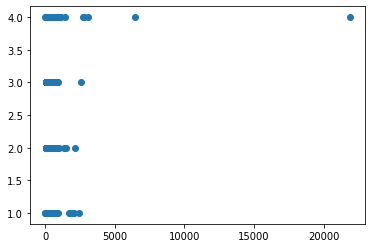

In [123]:
plt.scatter(df.monetary, df.payment_value)

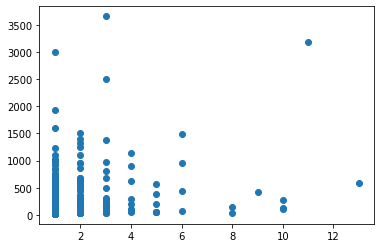

In [104]:
plt.scatter(df.frequency, df.payment_value)

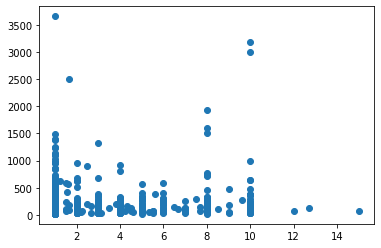

In [105]:
plt.scatter(df.installments, df.payment_value)

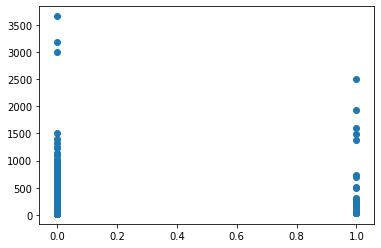

In [106]:
plt.scatter(df.pop_category_relogios_presentes, df.payment_value)

In [138]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

Train Accuracy:  0.23852276439068
Test Accuracy:  -0.12274045001757461


## Quartile-based

In [149]:
df_q4 = df
df_q4.payment_value = pd.qcut(df_q4.payment_value, 4, labels=[1, 2, 3, 4])
df_q4

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.000000,1.0,1.000000,0.0,1.000000,1,0,...,0,0,0,0,0,0,0,0,0,1
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.000000,2.0,3.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,2
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.000000,5.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,4
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.000000,9.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,4
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.000000,3.0,4.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc19fe9ac733e36ff8227c29435c2030,430,2,60.86,-30.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,2
fcd0ab79592faab19e2bf386cf69fbcd,414,1,45.95,-27.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,1,0,0,0,0,1
fd8ccc89be43894d2553494c71a61fd8,18,3,206.01,-22.000000,1.0,4.666667,0.0,1.000000,0,1,...,0,1,0,0,0,0,0,0,0,4


In [151]:
from scipy import stats
corr_array=[]
for i in range(df_q4.shape[1]-1):  
    corr_array.append([df_q4.columns[i], 
    np.abs(stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[0]),
    stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[0],
    stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[1]])
        
corr_df_q4 = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df_q4.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df_q4.reset_index(drop = True, inplace = True)
corr_df_q4

,Info,abs_corr,corr,p_value
0,frequency,1.096889e-01,1.096889e-01,0.006010
1,monetary,9.458501e-02,9.458501e-02,0.017928
2,customer_state_SP,8.291746e-02,-8.291746e-02,0.038077
3,customer_state_RN,7.585857e-02,7.585857e-02,0.057838
4,pop_category_moveis_decoracao,7.563794e-02,-7.563794e-02,0.058573
...,...,...,...,...
78,customer_state_RO,6.938894e-18,-6.938894e-18,1.000000
79,customer_state_RJ,3.469447e-18,3.469447e-18,1.000000
80,customer_state_SC,1.734723e-18,1.734723e-18,1.000000
81,customer_state_PE,0.000000e+00,0.000000e+00,1.000000


## Binary

In [153]:
df_q2 = df
df_q2.payment_value = pd.qcut(df_q2.payment_value, 2, labels=[0, 1])
df_q2

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.000000,1.0,1.000000,0.0,1.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.000000,2.0,3.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.000000,5.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,1
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.000000,9.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,1
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.000000,3.0,4.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc19fe9ac733e36ff8227c29435c2030,430,2,60.86,-30.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,0
fcd0ab79592faab19e2bf386cf69fbcd,414,1,45.95,-27.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,1,0,0,0,0,0
fd8ccc89be43894d2553494c71a61fd8,18,3,206.01,-22.000000,1.0,4.666667,0.0,1.000000,0,1,...,0,1,0,0,0,0,0,0,0,1


In [154]:
from scipy import stats
corr_array=[]
for i in range(df_q2.shape[1]-1):  
    corr_array.append([df_q2.columns[i], 
    np.abs(stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[0]),
    stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[0],
    stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[1]])
        
corr_df_q2 = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df_q2.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df_q2.reset_index(drop = True, inplace = True)
corr_df_q2

,Info,abs_corr,corr,p_value
0,review_score,8.408877e-02,-8.408877e-02,0.035429
1,pop_category_cool_stuff,8.097763e-02,8.097763e-02,0.042833
2,customer_state_MA,8.019269e-02,8.019269e-02,0.044895
3,frequency,7.690035e-02,7.690035e-02,0.054474
4,pop_category_climatizacao,6.939315e-02,6.939315e-02,0.082770
...,...,...,...,...
78,customer_state_SC,1.040834e-17,-1.040834e-17,1.000000
79,customer_state_AL,6.938894e-18,6.938894e-18,1.000000
80,pop_category_consoles_games,6.938894e-18,-6.938894e-18,1.000000
81,pop_category_instrumentos_musicais,3.469447e-18,-3.469447e-18,1.000000


In [ ]:
plt.scatter(common_customer_df.review_score, common_customer_df.payment_value)

In [ ]:
plt.scatter(common_cust.delay, common_cust.payment_value)

In [ ]:
boleto_series = common_cust.loc[common_cust.payment_type_boleto==1, 'payment_value']
credit_series = common_cust.loc[common_cust.payment_type_credit_card==1, 'payment_value']
debit_series = common_cust.loc[common_cust.payment_type_debit_card==1, 'payment_value']
voucher_series = common_cust.loc[common_cust.payment_type_voucher==1, 'payment_value']

type_dict = {}
type_dict['boleto'] = boleto_series.sum()/boleto_series.count()
type_dict['credit'] = credit_series.sum()/credit_series.count()
type_dict['debit'] = debit_series.sum()/debit_series.count()
type_dict['voucher'] = voucher_series.sum()/voucher_series.count()

type_dict

In [ ]:
X = common_cust.iloc[:,:-1]
y = common_cust.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

from sklearn.model_selection import cross_val_score
print('CV Score:', np.mean(cross_val_score(lr, X_train, y_train, cv = 5)))

In [ ]:
rfm1_df = poc1_df.groupby('customer_unique_id').agg({'purchase_date':'max', 'order_id':'count', 'payment_value':'sum'})
rfm1_df.columns = ['recency', 'frequency', 'monetary']
rfm1_df

In [ ]:
rfm1_df.recency = rfm1_df.recency.apply(lambda x: (poc1_df.purchase_date.max()-x).days)
rfm1_df

In [ ]:
#rfm1_df = pd.read_csv('rfm3m.csv', index_col=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm1_df)
X_scaled = scaler.transform(rfm1_df)
rfm1_km = KMeans(n_clusters=4).fit(X_scaled)

In [ ]:
plt.scatter(rfm1_df.recency, rfm1_df.monetary, c=rfm1_km.labels_)

In [ ]:
plt.scatter(rfm1_df.frequency, rfm1_df.monetary, c=rfm1_km.labels_)

In [ ]:
rfm2_df = poc2_df.groupby('customer_unique_id').agg({'purchase_date':'max', 'order_id':'count', 'payment_value':'sum'})
rfm2_df.columns = ['recency', 'frequency', 'monetary']
rfm2_df

In [ ]:
m2 = rfm2_df[['monetary']]

In [ ]:
clust1_df = pd.DataFrame()
clust1_df['customer_unique_id'] = rfm1_df.index
clust1_df['segment'] = rfm1_km.labels_
clust1_df

In [ ]:
common_cust = pd.merge(clust1_df, m2, on='customer_unique_id')
common_cust

In [ ]:
X = np.array(common_cust.segment).reshape(-1, 1)
y = common_cust.monetary

In [ ]:
plt.scatter(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

In [ ]:
lr.coef_

In [ ]:
rfm1_m2_df = pd.merge(rfm1_df, m2, left_index=True, right_index=True)
rfm1_m2_df

In [ ]:
plt.scatter(rfm1_m2_df.recency, rfm1_m2_df.monetary_y)

In [ ]:
plt.scatter(rfm1_m2_df.frequency, rfm1_m2_df.monetary_y)

In [ ]:
plt.scatter(rfm1_m2_df.monetary_x, rfm1_m2_df.monetary_y)

In [ ]:
X = rfm1_m2_df.iloc[:,:-1]
y = rfm1_m2_df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

In [ ]:
lr.coef_

In [ ]:
common_cust[['monetary']]

In [ ]:
m6m_km = KMeans(n_clusters=2)
m6m_km.fit(common_cust[['monetary']])
plt.scatter(common_cust.monetary, np.zeros([1,common_cust.shape[0]]), c=m6m_km.labels_)

In [ ]:
1-m6m_km.labels_.mean()

In [ ]:
plt.scatter(common_cust.rfm_clust_3m, m6m_km.labels_)

In [ ]:
from sklearn.linear_model import LogisticRegression 
clust_lr = LogisticRegression().fit(common_cust[['rfm_clust_3m']], m6m_km.labels_)

In [ ]:
clust_lr.score(common_cust[['rfm_clust_3m']], m6m_km.labels_)